<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/Boltzmann_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Boltzmann Distribution through Molecular Dynamics

This notebook demonstrates fundamental concepts in statistical mechanics through a simple 2D molecular dynamics simulation. By watching how energy distributes among particles in a confined system, we'll explore key concepts like:

- **Microstates vs Macrostates**: Individual particle configurations vs observable bulk properties
- **Energy Distribution**: How kinetic energy spreads among particles over time
- **Equilibrium**: The tendency of isolated systems to reach stable energy distributions
- **Temperature**: As a measure of average kinetic energy per particle

## Learning Objectives

By the end of this simulation, you should understand:
1. How individual particle motions (microstates) give rise to observable properties (macrostates)
2. Why energy naturally distributes according to statistical laws
3. The connection between molecular motion and temperature
4. How simulations can be used to estimate observable properties, and such properties be used to tune simulations to be more predictive.

## The Simulation Setup

We'll simulate **hard sphere collisions** in a 2D box:
- Particles bounce off walls and each other
- Energy is transferred between balls stochastically
- We can track, plot, and count everything that happens

### Why

This defines a closed system where we can define meaningful macrostates, enthalpies and entropies. this exercise will give you a sense of what they actually mean, and allow you to also estimate these terms directly from a simulation. As you will find out, we often want to simulate systems where the enthalpy and entropy is not known or possible to calculate, and where this type of simulation is a powerful tool.

### What to do

As before, execute the blocks in turn, and **READ ALL INSTRUCTIONS** in between.

Lets import the basics

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Running the Simulation

### Running
The simulation consists of several key components:
1. **Parameters**: Define what to simulate and how
2. **Initialization**: Set up random positions and give one particle an initial velocity
3. **Physics Loop**: Handle collisions and update positions

### Analysis
After completing the simulation, you can analyse the simulation in multiple ways
1. **Visualization**: Animate the results and see what happened
2. **Calculate**: Calculate macroscopic properties that help you quantify and understand the simulation beyond just looking at it.

Lets run a short simulation. This will **NOT** plot or show anything, just run the simulation.  

In [ ]:
# @title Simulation
import os
import time

# Example: use 8 threads
os.environ["NUMBA_NUM_THREADS"] = "8"

# Optional: check how many threads Numba will use
from numba import get_num_threads, set_num_threads
print("Default threads:", get_num_threads())

# You can also change it at runtime:
set_num_threads(8)
print("Now using:", get_num_threads())

import numpy as np

# @title
# -------------------
# Parameters
# -------------------
n_balls = 11        #@param {type:"integer"} # Number of particles (default: 15)
box_size = 2         # Size of the simulation box  (default: 2)
radius = 0.1        #@param {type:"number"} # Particle radius (default: 0.1)
timestep = 0.02      #@param {type:"number"} # Time step (default: 0.05)
simulation_steps = 5000        #@param {type:"integer"}
# Number of simulation steps (default 400, you might not plot all your steps, depending on memory reqs.)
rescale_interval = 5   # How often to rescale velocities (0 = never, default: 50)
elastic_loss = 0    #@param {type:"number"} # Energy loss per collision (0 = perfectly elastic, other wise on [0,1] )
initial_vel = 3     #@param {type:"number"}
  # Initial velocity of the first ball (default: 3)

dt = timestep
n_steps = simulation_steps

# Interaction (Coulomb-like with softening for performance/robustness)
k_int = 1.0                         # interaction strength (set smaller if things blow up)
q_mag = 0                          # magnitude of each charge
charges = np.full(n_balls, q_mag)   # same sign and magnitude by default (repulsion if all same sign)

# To make first and second ball favour each other
binding = False
if binding:
  charges[0] *= -3
  charges[1] *= 3

# For numerical stability
soft2 = (0.03)**2             # softening length^2 to avoid singularities at tiny r
cutoff = 0.6 #None            # set to a float (e.g. 0.8) to skip interactions beyond this distance for speed

# -------------------
# New Parameters
# -------------------
anneal_frames = -1  # Cool down the system to 0 temperature over this many frames by adjusting the target energy (default: -1, meaning don't cool down)
anneal_target = 60       # Annealing target, i.e. multiplier for inital energy.
initial_configuration = 'random' #@param ["random", "lattice"]

# -------------------
# Helper functions
# -------------------
def kinetic_energy(v):
    return 0.5 * np.sum(v**2, axis=1)

def rescale_velocities(vel, target_energy):
    current_energy = np.sum(kinetic_energy(vel))
    factor = np.sqrt(target_energy / current_energy)
    return vel * factor

def get_markersize(diam, plot_width, figsize):
    """Get scatter plot marker size for a diameter.

    Args:
        diam (float): diameter of the marker
        plot_width (float): width of the plot
        figsize (int, optional): size of the fig. Defaults to 8.

    Returns:
        float: marker size in points
    """
    points_whole_ax = figsize * 0.8 * 72    # 1 point = dpi / 72 pixels
    s = (diam / plot_width * points_whole_ax)**2
    return s

def mitchell_best_candidate(n_balls, box_size, radius, n_candidates=100):
    """
    Generates space-excluding 2D positions using Mitchell's Best Candidate algorithm.

    Args:
        n_balls (int): The number of particles to generate positions for.
        box_size (float): The size of the square simulation box.
        radius (float): The radius of the particles.
        n_candidates (int): The number of candidate positions to consider in each step.

    Returns:
        np.ndarray: An array of shape (n_balls, 2) containing the generated positions.
                    Returns an empty array if not enough positions could be found.
    """
    positions = []
    min_dist_sq = (2 * radius)**2
    box_min = radius
    box_max = box_size - radius

    # Generate the first particle position randomly
    x = np.random.uniform(box_min, box_max)
    y = np.random.uniform(box_min, box_max)
    positions.append(np.array([x, y]))

    # Generate subsequent particle positions
    failed_tries = 0

    while len(positions) < n_balls:
        best_candidate = None
        max_min_dist_sq = -1

        # Generate and evaluate candidates
        candidates = np.random.uniform(box_min, box_max, size=(n_candidates, 2))

        for candidate in candidates:
            # Calculate squared distances to existing positions
            existing_positions = np.array(positions)
            delta = existing_positions - candidate
            distances_sq = np.sum(delta**2, axis=1)

            # Find the minimum squared distance for this candidate
            min_dist_sq_to_existing = np.min(distances_sq)

            # Check if this candidate is better than the current best
            if min_dist_sq_to_existing > max_min_dist_sq:
                max_min_dist_sq = min_dist_sq_to_existing
                best_candidate = candidate

        # Accept the best candidate if it satisfies the minimum distance criterion
        if max_min_dist_sq >= min_dist_sq:
            positions.append(best_candidate)
        else:
            failed_tries += 1

        # If failing, decrease min_dist
        if failed_tries > 100:
            min_dist_sq *= 0.9
            if failed_tries > 1000:
                min_dist_sq = 0.0

    return np.array(positions)

# -------------------
# Initialization (unchanged except minor cleanup)
# -------------------
rng = np.random.default_rng(0)

if initial_configuration == 'random':
    #pos = rng.random((n_balls, 2)) * (box_size - 2*radius) + radius
    pos = mitchell_best_candidate(n_balls, box_size, radius)

else:
    lattice_spacing = 2 * radius * 1.0
    num_points_x = int(box_size / lattice_spacing) + 3
    base_line_x = np.arange(num_points_x) * lattice_spacing
    base_line_y = np.zeros(num_points_x)
    base_line = np.vstack([base_line_x, base_line_y]).T

    positions = []
    rows_to_generate = int(box_size / (lattice_spacing * np.sin(np.pi/3))) + 3
    y_shift = lattice_spacing * np.sin(np.pi/3)
    x_shift = radius

    for row in range(rows_to_generate):
        current_y = row * y_shift
        current_line = base_line.copy()
        if row % 2 == 1:
            current_line[:, 0] += x_shift
        current_line[:, 1] += current_y
        positions.append(current_line)

    positions = np.vstack(positions)

    box_center = np.array([box_size / 2, box_size / 2])
    distances_to_box_center = np.linalg.norm(positions - box_center, axis=1)
    closest_point_index = np.argmin(distances_to_box_center)
    shift_to_center = box_center - positions[closest_point_index]
    positions += shift_to_center

    distances_to_box_center_shifted = np.linalg.norm(positions - box_center, axis=1)
    sorted_indices = np.argsort(distances_to_box_center_shifted)
    pos = positions[sorted_indices[:n_balls]]
    pos = np.clip(pos, radius, box_size - radius)

vel = np.zeros((n_balls, 2))
v = rng.standard_normal(2)
vel[0] = initial_vel * v / np.linalg.norm(v)

# -------------------
# Helper functions (vectorized & numba-accelerated versions)
# -------------------
def kinetic_energy(v):
    return 0.5 * np.sum(v**2, axis=1)

def rescale_velocities_to_total_energy(vel, target_total_E, current_PE):
    KE = np.sum(kinetic_energy(vel))
    desired_KE = target_total_E - current_PE
    if desired_KE <= 0 or KE <= 0:
        return vel
    return vel * np.sqrt(desired_KE / KE)

def center_of_mass(pos, masses=None):
    if masses is None:
        masses = np.ones(pos.shape[0])
    total_mass = np.sum(masses)
    if total_mass == 0:
        return np.zeros(pos.shape[1])
    return (pos * masses[:, None]).sum(axis=0) / total_mass

def remove_com_velocity(vel, masses=None):
    if masses is None:
        masses = np.ones(vel.shape[0])
    total_mass = np.sum(masses)
    if total_mass == 0:
        return vel
    com_vel = (vel * masses[:, None]).sum(axis=0) / total_mass
    return vel - com_vel

def remove_total_rotational_momentum_2d(pos, vel):
    n = pos.shape[0]
    com_pos = pos.mean(axis=0)
    com_vel = vel.mean(axis=0)
    pos_com = pos - com_pos
    vel_com = vel - com_vel
    total_L = np.sum(pos_com[:, 0] * vel_com[:, 1] - pos_com[:, 1] * vel_com[:, 0])
    inertia = np.sum(np.sum(pos_com**2, axis=1))
    if inertia > 1e-9:
        omega = total_L / inertia
        vel_corr = np.empty_like(vel_com)
        vel_corr[:, 0] = -omega * pos_com[:, 1]
        vel_corr[:, 1] =  omega * pos_com[:, 0]
        vel_com -= vel_corr
    return vel_com + com_vel

# ---- Try to use Numba for O(N^2) kernels ----
_use_numba = False
try:
    from numba import njit, prange
    _use_numba = True
except Exception:
    _use_numba = False

if _use_numba:
    @njit(parallel=True, fastmath=True)
    def _pairwise_forces_and_pe_numba(pos, charges, k_int, soft2, cutoff, all_attractive):
        n = pos.shape[0]
        F = np.zeros_like(pos)
        PE = 0.0
        for i in prange(n):
            xi0 = pos[i, 0]
            xi1 = pos[i, 1]
            ci = charges[i]
            for j in range(i+1, n):
                dx = xi0 - pos[j, 0]
                dy = xi1 - pos[j, 1]
                r2 = dx*dx + dy*dy
                if cutoff > 0.0 and r2 > cutoff*cutoff:
                    continue
                inv_r_soft = 1.0 / np.sqrt(r2 + soft2)
                qiqj = ci * charges[j]
                if all_attractive:
                    qiqj = -abs(qiqj)
                pe_ij = k_int * qiqj * inv_r_soft
                PE += pe_ij
                inv_r3 = inv_r_soft * inv_r_soft * inv_r_soft
                fx = k_int * qiqj * dx * inv_r3
                fy = k_int * qiqj * dy * inv_r3
                F[i, 0] += fx
                F[i, 1] += fy
                F[j, 0] -= fx
                F[j, 1] -= fy
        return F, PE

    @njit(parallel=True, fastmath=True)
    def _collisions_numba(pos, vel, radius):
        n = pos.shape[0]
        for i in prange(n):
            for j in range(i+1, n):
                dx = pos[i,0] - pos[j,0]
                dy = pos[i,1] - pos[j,1]
                dist2 = dx*dx + dy*dy
                min_d = 2.0*radius
                if dist2 < (min_d * min_d) and dist2 > 1e-24:
                    dist = np.sqrt(dist2)
                    overlap = (min_d - dist)
                    nx = dx / dist
                    ny = dy / dist
                    pos[i,0] += 0.5 * overlap * nx
                    pos[i,1] += 0.5 * overlap * ny
                    pos[j,0] -= 0.5 * overlap * nx
                    pos[j,1] -= 0.5 * overlap * ny
                    dvx = vel[i,0] - vel[j,0]
                    dvy = vel[i,1] - vel[j,1]
                    v_rel_n = dvx * nx + dvy * ny
                    if v_rel_n < 0.0:
                        imp_x = v_rel_n * nx
                        imp_y = v_rel_n * ny
                        vel[i,0] -= imp_x
                        vel[i,1] -= imp_y
                        vel[j,0] += imp_x
                        vel[j,1] += imp_y

    def pairwise_forces_and_pe(pos, charges, k_int, soft2, cutoff, all_attractive=True):
        cto = cutoff if (cutoff is not None) else -1.0
        return _pairwise_forces_and_pe_numba(pos, charges, k_int, soft2, cto, all_attractive)

    def resolve_collisions(pos, vel, radius):
        _collisions_numba(pos, vel, radius)

else:
    # ---- NumPy vectorized fallback (still fast) ----
    def pairwise_forces_and_pe(pos, charges, k_int, soft2, cutoff, all_attractive=True):
        # Build pairwise deltas
        dp = pos[:, None, :] - pos[None, :, :]          # (n,n,2)
        r2 = np.einsum('ijk,ijk->ij', dp, dp)           # (n,n)
        if cutoff is not None:
            mask = (r2 > 0) & (r2 <= cutoff*cutoff)
        else:
            mask = (r2 > 0)

        inv_r_soft = np.zeros_like(r2)
        inv_r_soft[mask] = 1.0 / np.sqrt(r2[mask] + soft2)

        qiqj = charges[:, None] * charges[None, :]
        if all_attractive:
            qiqj = -np.abs(qiqj)

        # Potential energy: sum over i<j
        pe_mat = k_int * qiqj * inv_r_soft
        i_up, j_up = np.triu_indices(pos.shape[0], 1)
        PE = np.sum(pe_mat[i_up, j_up])

        inv_r3 = inv_r_soft**3
        f_ij = (k_int * qiqj)[..., None] * dp * inv_r3[..., None]   # (n,n,2)
        np.fill_diagonal(f_ij[..., 0], 0.0)
        np.fill_diagonal(f_ij[..., 1], 0.0)

        F = f_ij.sum(axis=1)  # net force on each i (sum over j)
        return F, PE

    def resolve_collisions(pos, vel, radius):
        n = pos.shape[0]
        i_up, j_up = np.triu_indices(n, 1)
        dp = pos[i_up] - pos[j_up]
        r2 = np.einsum('ij,ij->i', dp, dp)
        min_d = 2 * radius
        overlap_mask = (r2 > 1e-24) & (r2 < (min_d*min_d))
        if not np.any(overlap_mask):
            return
        dp = dp[overlap_mask]
        i_idx = i_up[overlap_mask]; j_idx = j_up[overlap_mask]
        dist = np.sqrt(np.einsum('ij,ij->i', dp, dp))
        n_hat = dp / dist[:, None]
        overlap = (min_d - dist)[:, None]
        # de-overlap
        pos[i_idx] += 0.5 * overlap * n_hat
        pos[j_idx] -= 0.5 * overlap * n_hat
        # relative normal velocity
        dv = vel[i_idx] - vel[j_idx]
        v_rel_n = np.einsum('ij,ij->i', dv, n_hat)
        hit = v_rel_n < 0
        if np.any(hit):
            imp = (v_rel_n[hit])[:, None] * n_hat[hit]
            vel[i_idx[hit]] -= imp
            vel[j_idx[hit]] += imp

# -------------------
# Precompute initial energies
# -------------------
F0, PE0 = pairwise_forces_and_pe(pos, charges, k_int, soft2, cutoff, all_attractive=not binding)
KE0 = np.sum(kinetic_energy(vel))
target_total_energy = KE0 + PE0
initial_energy = KE0

# -------------------
# Simulation
# -------------------
start_time = time.time() # Start timing

F, PE = F0, PE0
acc = F

center_com_interval = 100

# Histories: preallocate for speed & lower memory churn
pos_history_1 = np.empty((n_steps, n_balls, 2), dtype=np.float64)
vel_history_1 = np.empty((n_steps, n_balls, 2), dtype=np.float64)
ke_history_1  = np.empty((n_steps, n_balls), dtype=np.float64)
pe_history_1  = np.empty((n_steps,), dtype=np.float64)
total_energy_history_1 = np.empty((n_steps,), dtype=np.float64)

box_min = radius
box_max = box_size - radius

for step in range(n_steps):
    # v(t+dt/2)
    vel += 0.5 * dt * acc

    # x(t+dt)
    pos += dt * vel

    # Vectorized wall collisions (reflective + optional loss)
    # X walls
    left_hit  = pos[:, 0] < box_min
    right_hit = pos[:, 0] > box_max
    if np.any(left_hit):
        pos[left_hit, 0] = box_min
        vel[left_hit, 0] *= -1.0
        if elastic_loss > 0:
            vel[left_hit, 0] *= (1 - elastic_loss)
    if np.any(right_hit):
        pos[right_hit, 0] = box_max
        vel[right_hit, 0] *= -1.0
        if elastic_loss > 0:
            vel[right_hit, 0] *= (1 - elastic_loss)
    # Y walls
    bottom_hit = pos[:, 1] < box_min
    top_hit    = pos[:, 1] > box_max
    if np.any(bottom_hit):
        pos[bottom_hit, 1] = box_min
        vel[bottom_hit, 1] *= -1.0
        if elastic_loss > 0:
            vel[bottom_hit, 1] *= (1 - elastic_loss)
    if np.any(top_hit):
        pos[top_hit, 1] = box_max
        vel[top_hit, 1] *= -1.0
        if elastic_loss > 0:
            vel[top_hit, 1] *= (1 - elastic_loss)

    # Hard-sphere collisions (batch)
    resolve_collisions(pos, vel, radius)

    # New forces at x(t+dt) – computed once per step (same final result)
    F, PE = pairwise_forces_and_pe(pos, charges, k_int, soft2, cutoff, all_attractive=not binding)
    acc = F

    # v(t+dt)
    vel += 0.5 * dt * acc

    loc_PE = PE
    # Optional total-energy rescaling
    if elastic_loss <= 0 and rescale_interval > 0 and (step % rescale_interval == 0):
        if anneal_frames > 0:
            frac = min(float(step / anneal_frames), 1.0)
            target_total_energy = initial_energy * (1 + frac * (anneal_target - 1))
            loc_PE = 0.0
            vel = remove_total_rotational_momentum_2d(pos, vel)
            vel = remove_com_velocity(vel)
        vel = rescale_velocities_to_total_energy(vel, target_total_energy, loc_PE)

    # Center COM periodically
    if anneal_frames > 0 and center_com_interval > 0 and (step % center_com_interval == 0):
        current_com = center_of_mass(pos)
        shift = (box_size / 2) - current_com
        pos += shift

    # Save history (no Python list appends)
    KE = kinetic_energy(vel)
    pos_history_1[step] = pos
    vel_history_1[step] = vel
    ke_history_1[step] = KE
    pe_history_1[step] = PE
    total_energy_history_1[step] = np.sum(KE) + PE

# Post
vel_mag_history_1 = np.linalg.norm(vel_history_1, axis=2)

end_time = time.time() # End timing
simulation_time = end_time - start_time

print(f"Simulation complete! Ran for {n_steps} steps with {n_balls} particles.")
print(f"Initial total energy: {initial_energy:.3f}")
print(f"Final total energy: {np.sum(ke_history_1[-1]):.3f}")
print(f"The simulation took {simulation_time:.2f} seconds.")

Default threads: 8
Now using: 8
Simulation complete! Ran for 5000 steps with 11 particles.
Initial total energy: 4.500
Final total energy: 4.500
The simulation took 1.40 seconds.


## Visualizing the Results
We can now take a look at the simulation. Running this code will probably take longer than the simulation, because plotting in python takes a bit of time. You can also choose to plot fewer than the total number of simulation frames, which will be important later (when you might want to simulate longer to get more statitics).
### What to Observe:

**Left Panel: Particle Motion (Microstates)**
- Watch how particles move and collide
- Notice how energy spreads from the initial fast particle to others

**Right Panel: Energy Evolution (Macrostates)**
- **Black line**: Total kinetic energy of the system
- **Red line**: Average speed of particles

**Key Questions to Consider:**
1. How would you describe the difference between the simulation at the first few frames and the last few frames?
2. What happens to the total energy?
3. How does the average speed evolve?

In [ ]:
# @title

# --- Parameters ---
start_frame = 0 #@param {type:"integer"}
end_frame = 500 #@param {type:"integer"}
frame_step = 5 #@param {type:"integer"}

end_frame = np.min([end_frame, n_steps])
frames_to_use = np.arange(start_frame, end_frame, frame_step)

# -------------------
# Animation
# -------------------
fsize=5

fig = plt.figure(figsize=(2*fsize, fsize))
ax = []
ax.append(plt.subplot(121))  # Left panel
ax.append(plt.subplot(222))  # Top-right panel
ax.append(plt.subplot(224))  # Bottom-right panel

# Left panel: particle positions
ax[0].set_xlim(0, box_size)
ax[0].set_ylim(0, box_size)
ax[0].set_xlabel('X Position')
ax[0].set_ylabel('Y Position')
ax[0].set_title('Particle Motion')
ax[0].set_aspect('equal')
scat = ax[0].scatter(pos_history_1[0,:,0], pos_history_1[0,:,1],
                     s=get_markersize(radius*2, box_size, fsize))

# Right panels: energy evolution
ax[1].set_xlim(0, n_steps)
ax[1].set_ylim(0, np.max([ke_history_1])*1.2)
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Kinetic energy')
grph1, = ax[1].plot(ke_history_1[:1].sum(axis=1),'k-', linewidth=2, label='Total KE')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

mean_vel_history_1 = vel_mag_history_1.mean(axis=1)
ax[2].set_xlim(0, n_steps)
ax[2].set_ylim(0, np.max(mean_vel_history_1)*1.2)
ax[2].set_xlabel('Time Step')
ax[2].set_ylabel('Speed')
grph2, = ax[2].plot(mean_vel_history_1,'r-', linewidth=2, label='Avg Speed')
ax[2].legend()
ax[2].grid(True, alpha=0.3)


def update(frame):
    scat.set_offsets(pos_history_1[frame])
    grph1.set_xdata(np.arange(frame+1))
    grph1.set_ydata(ke_history_1[:frame+1].sum(axis=1))
    grph2.set_xdata(np.arange(frame+1))
    grph2.set_ydata(vel_mag_history_1[:frame+1].mean(axis=1))
    return scat, grph1, grph2

ani = FuncAnimation(fig, update, frames=frames_to_use, interval=50, blit=True)
plt.tight_layout()
plt.close(fig)
HTML(ani.to_jshtml())

## Experiments to Try

Now that you've seen the basic simulation, try modifying the parameters above and re-running to explore different scenarios:

### Experiment 1: Energy Loss
Set `elastic_loss = 0.05`. What happens to the system over time? Try to formulate your own statement using the concepts covered, before clicking to see the answer.

<details>
  <summary> Answer (click to expand)</summary>
  <p>Since you only lose energy, the temperature and pressure will drop. So, the system cools down. </p>
</details>


### Experiment 2: Initial Conditions
Set the intial velocity higher by changing `initial_vel`. What macroscopic (real world) properties have you changed by doing this? That is, if you think of these as atoms in a gas, what is different at higher velocity?

<details>
  <summary> Answer (click to expand)</summary>
  <p>By increasing the velocity, you have increased the energy. By consequence you have raised the pressure and temperature.</p>
</details>



How would you calculate those properties from the simulation? That is, is there some property of the simulation that can extract to put in terms of more familiar concepts?
<details>
  <summary> Answer (click to expand)</summary>
  <p>Look at the boltzmann distribution and think about terms in it, and things you can work out from the simulation. You might also look for other thermodynamic relations and equations. </p>
</details>

## Additional Analysis

Let's go back to using 0 elastic loss for just 200 frames. Run that simulation, an use the following block to look at some plots of all balls averaged over the entire simulation:

**TIP**:  You do **NOT** need to run the time-consuming visualization for this step to work, so you can re-run the simulation, skip the visulaization, and jump to this analysis. This is going to be useful for later steps where we run longer simulations.

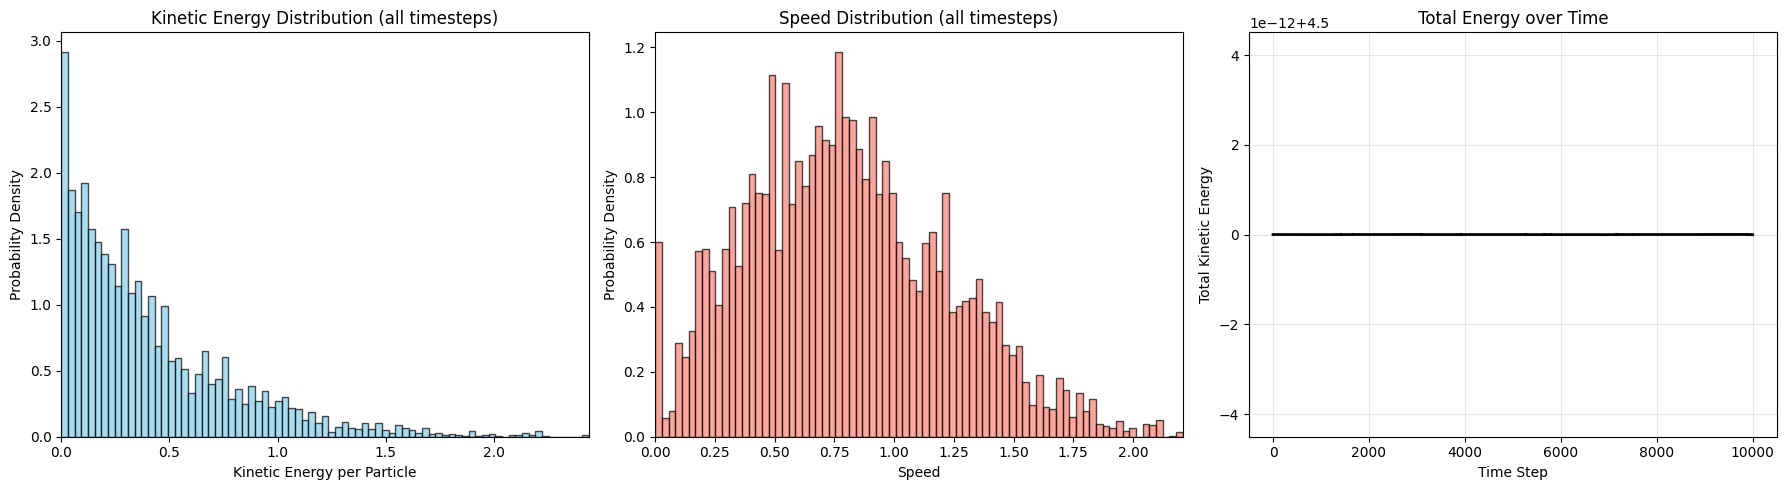

Energy conservation check:
Initial total energy: 4.5000
Final total energy:   4.5000
Relative change: -0.00%


In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np

# Assuming:
# ke_history: shape (n_steps, n_particles)
# vel_history: shape (n_steps, n_particles, ndim)   # full velocities
# n_steps: total number of steps

# --- 1. Gather data for distributions ---
all_ke = ke_history_1.ravel()
speeds = np.linalg.norm(vel_history_1, axis=2)  # shape (n_steps, n_particles)
all_speeds = speeds.ravel()

# --- 2. Compute total energy over time ---
total_energy = ke_history_1.sum(axis=1)

# --- 3. Compute 99.9% percentile for x-axis limits ---
ke_xlim = np.percentile(all_ke, 99.9)
speed_xlim = np.percentile(all_speeds, 99.9)

# --- 4. Make the plots ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # Create 1 row, 3 columns for subplots

# (a) Histogram of kinetic energy distribution
axes[0].hist(all_ke, bins=np.linspace(0,ke_xlim,80), density=True, color="skyblue", edgecolor="k", alpha=0.7)
axes[0].set_xlim(0, ke_xlim)
axes[0].set_xlabel("Kinetic Energy per Particle", fontsize=10) # Reduced font size
axes[0].set_ylabel("Probability Density")
axes[0].set_title("Kinetic Energy Distribution (all timesteps)")

# (b) Histogram of speed distribution (MB-like)
axes[1].hist(all_speeds, bins=np.linspace(0,speed_xlim,80), density=True, color="salmon", edgecolor="k", alpha=0.7)
axes[1].set_xlim(0, speed_xlim)
axes[1].set_xlabel("Speed", fontsize=10) # Reduced font size
axes[1].set_ylabel("Probability Density")
axes[1].set_title("Speed Distribution (all timesteps)")

# (c) Total energy over time
axes[2].plot(total_energy, "k-", linewidth=2)
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("Total Kinetic Energy")
axes[2].set_title("Total Energy over Time")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Energy conservation check ---
print("Energy conservation check:")
print(f"Initial total energy: {total_energy[0]:.4f}")
print(f"Final total energy:   {total_energy[-1]:.4f}")
print(f"Relative change: {(total_energy[-1] - total_energy[0]) / total_energy[0] * 100:.2f}%")

### Questions:
1. Looking at the plot of speed distribution (red, center plot), what is the peak at very low speed?
<details>
  <summary> Answer (click to expand)</summary>
  <p>Initially, all balls are fairly still, and since this looks at tjhe whole simulation, it seems fairly "common" for them to be slow. </p>

  <p>We say that the system is in non-equilibrium, since it is in a very low-entropy state that is extremely unlikely, and still driving towards an equilibrium state at higher entropy.</p>
</details>

2. How could you make sure that this plot shows equilibrium?
<details>
  <summary> Answer (click to expand)</summary>
  <p>If you run the simulation for much longer, the inital phase becomes negligible. More realistically, yoiu could also start the simulation with more than one ball moving. Try running the simulation for longer, say 10'000 steps. </p>
</details>

3. At equilibrium, what distribution of energy and velocity (speed) do you find? Do you recognize them?
<details>
  <summary> Answer (click to expand)</summary>
  <p> The speed distribution should look like the Maxwell-Boltzmann distribution. Can you think of simulation settings where it does not? </p>
</details>

## Connecting to Statistical Mechanics

### Microstates vs Macrostates
- **Microstate**: The exact position and velocity of every particle at a given time
- **Macrostate**: Observable quantities like total energy, average speed, temperature

### Energy Distribution and Temperature
In a real gas, the Boltzmann distribution tells us the probability of finding a particle with energy E:

$$P(E) \propto e^{-E/k_BT}$$

Where:
- $k_B$ is Boltzmann's constant
- $T$ is temperature

A higher temperature thus means a broader energy distribution

### Entropy and Equilibrium
- The system naturally evolves toward states with maximum entropy
- Equilibrium represents the most probable macrostate
- Individual microstates are constantly changing, but macroscopic properties stabilize over time

## Discussion Questions

1. **Equilibration Time**: How long does it take for energy to distribute evenly? What factors affect this?

2. **Reversibility**: Is this process reversible? Could all energy spontaneously return to one particle?

3. **Temperature**: If temperature is proportional to average kinetic energy, how would you define temperature in this system?

4. **Real vs Ideal**: How does this simplified model compare to real gas behavior?

5. **Scaling**: What would happen with 1000 particles? $10^{23}$ particles (like in a real gas)?

# Part 2 : Enthalpy and entropy

Now we will dig in a bit more into microstates and macrostates, and define them a bit differently in order to understand their free energy. It can be confusing, but we can define microstates as any *kind* of configuration, not just the state of a whole closed system. Sure, the position and velocity of every ball defines the microstate, but we can also reduce this to consider only the distance of all balls to all other balls.

To be a bit more tangible still, lets define three macrostates as follows and try to count how many microstates are in each one:

- ball A is bound to ball B (defined as within a distance of 0.25 a.u.)
- ball A is bound to any other ball
- ball A is unbound

In this scenario, we can think of the simulation as a model for a protein (ball A) in solution that can bind a ligand (ball B), or something non-specific (any other ball).

To count microstates by enumerating them, even in this simple case, becomes VERY difficult. But lets try by making things simple.

## Make the simulation smaller

Change the seetings as follows:
 - Reduce the number of balls to 11
 - Increase the radius to 0.1
 - 5000 steps

Visualize the simulations first 500 frames (use frame_step=5 to get a movie of 100 frames)

## Analyse population of states

So instead of asking "how many ways can ball A be bound to ball B?" and trying to formulate that through a geometric or mathematical construction, we can run a simulation to simply count. Especially for the converese question "how many ways is there for ball A to be unbound?", this is much easier. It would also depend on how much energy there is in the system, and how it distributes. Complicated math, easy to simulate.

**NOTE:** Here, the balls do not interact, so there is no binding energy to consider, only entropy. The free energy of the macrostates defined above and their differences thus reduce to

$$\Delta F = -T \cdot \Delta S$$

Run the analysis code below and see if it matches your expectations based on what the simulation looked like. and adress the questions that follow

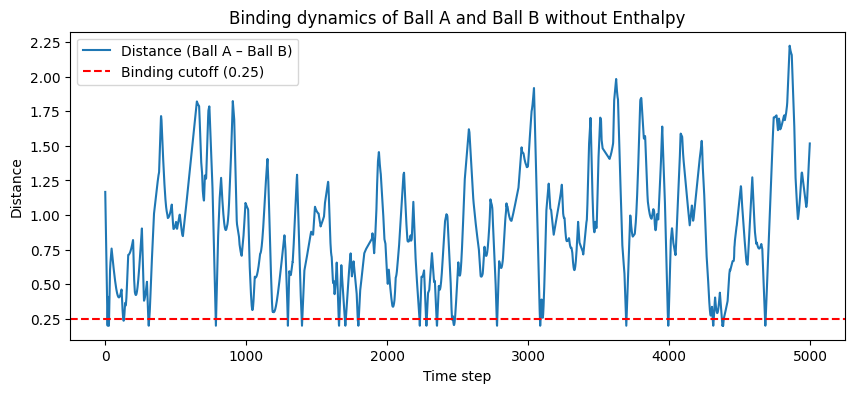

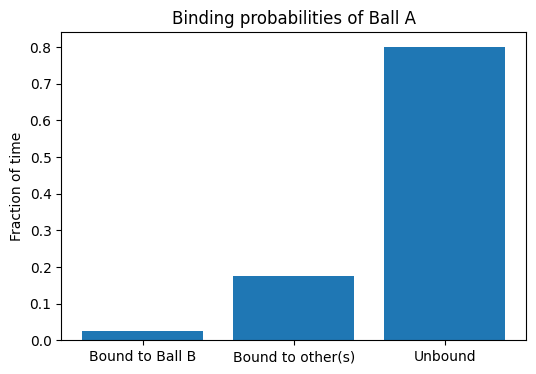

In [ ]:
# @title Binding State Analysis
# -------------------
# Binding analysis
# -------------------
r_bind = radius*2.5
bound_to_1_frames = []
bound_to_others_frames = []
unbound_frames = []

# distances of particle 0 to all others, shape = (n_steps, n_particles-1)
# Need to handle case where n_balls is 0 or 1
if n_balls > 1:
    dists = np.linalg.norm(pos_history_1[:, 1:,:] - pos_history_1[:, [0],:], axis=2)

    # binding checks (mutually exclusive states)
    is_bound_to_1 = (dists[:, 0] < r_bind)
    is_bound_to_any_other = (np.any(dists[:, 1:] < r_bind, axis=1))

    # State 1: Bound to Ball 1 (and potentially others)
    bound_to_1_frames = is_bound_to_1.astype(int)

    # State 2: Bound to others (excluding Ball 1) - bound to any other AND NOT bound to ball 1
    bound_to_others_frames = (is_bound_to_any_other & (~is_bound_to_1)).astype(int)

    # State 3: Unbound - NOT bound to ball 1 AND NOT bound to any other
    unbound_frames = (~is_bound_to_1 & ~is_bound_to_any_other).astype(int)


    dist_01 = dists[:, 0]  # distance from particle 0 to 1

    plt.figure(figsize=(10,4))
    plt.plot(dist_01, label="Distance (Ball A – Ball B)")
    plt.axhline(r_bind, color="r", linestyle="--", label=f"Binding cutoff ({r_bind:.2f})")
    plt.xlabel("Time step"); plt.ylabel("Distance")
    plt.title("Binding dynamics of Ball A and Ball B without Enthalpy")
    plt.legend()
    plt.show()

    # Bar plot of binding frequencies
    counts = [
        np.sum(bound_to_1_frames),
        np.sum(bound_to_others_frames),
        np.sum(unbound_frames)
    ]

    labels = ["Bound to Ball B", f"Bound to other(s)", "Unbound"]

    total_frames = len(bound_to_1_frames)
    if total_frames > 0:
        plt.figure(figsize=(6,4))
        plt.bar(labels, np.array(counts)/total_frames)
        plt.ylabel("Fraction of time")
        plt.title("Binding probabilities of Ball A")
        plt.show()
    else:
        print("No simulation data available to calculate binding probabilities.")

elif n_balls == 1:
    print("Only one particle in the simulation. Binding analysis requires at least two particles.")
else:
    print("No particles in the simulation.")

# Entropy/Enthalpy analysis
kB = 1.0
Omega_A = 1
Omega_B = n_balls - 2
Omega_C = 1

S_A = kB * np.log(Omega_A)
S_B = kB * np.log(Omega_B)
S_C = kB * np.log(Omega_C)

# Estimate average interaction energy in each state
def interaction_energy(qi, qj, r, k=1.0):
    return k * qi * qj / r

U_A, U_B = [], []
# Ensure pos_history_1 is not empty and has enough particles for analysis
if len(pos_history_1) > 0 and n_balls > 1:
    for step in range(len(pos_history_1)):
        pos0 = pos_history_1[step, 0]
        # Calculate distances from particle 0 to all other particles including particle 1
        dists_all = np.linalg.norm(pos_history_1[step] - pos0, axis=1)

        # Check if particle 0 is bound to particle 1 in this step
        if dists_all[1] < r_bind:
            U_A.append(interaction_energy(charges[0], charges[1], dists_all[1]))
        # Check if particle 0 is bound to any other particle (excluding particle 1) in this step
        for j in range(2, n_balls):
            if dists_all[j] < r_bind:
                U_B.append(interaction_energy(charges[0], charges[j], dists_all[j]))


### Boltzmann Inversion and Relative Entropy
**Question 1**: Based on the bar chart of binding probabilities, which state has the highest entropy?

<details>
<summary>Answer (click to expand)</summary>
The state with the highest probability (fraction of time) has the highest entropy. In the example run, this is likely the "Unbound" state, as there are many more configurations where the first ball is not close to any other specific ball compared to being bound to a particular one.
</details>

**Question 2**: Consider just the math for a second. Can you express the difference in entropy beteen two states in terms of their populations?

<details>
<summary>Hint (click to expand)</summary>
Use $$P(State) \propto e^{-F/k_BT}$$
and
$$\Delta F = -T \cdot \Delta S$$
to solve for $$\Delta S$$
</details>

<details>
<summary>Answer (click to expand)</summary>
we can use the populations of the macrostates we just calculated to estimate the relative free energy difference between them using the Boltzmann distribution. The relationship between the probability of being in a state and its free energy is given by:

$$P(State) \propto e^{-F/k_BT}$$

Where:
- $P(State)$ is the probability (or fraction of time) the system spends in that state.
- $F$ is the free energy of the state.
- $k_B$ is Boltzmann's constant.
- $T$ is the temperature.

From this, the free energy difference between two states, A and B, can be related to their probabilities:

$$\Delta F = F_B - F_A = -k_BT \ln \left(\frac{P(B)}{P(A)}\right)$$

In our case, since there are no direct interactions between the particles, the free energy difference is given by the entropy difference:

$$\Delta F = -T \Delta S$$

So,

$$\Delta S_{AB} = -k_B \ln \left(\frac{P(B)}{P(A)}\right)$$
</details>

**NOTE**: the Boltzmann constant here is in terms of units this simulation does not enforce, so it doesn't make sense to scale the entropy by it. For this toy simulation where we say e.g. radius=1 without saying what the unit is (cm/m/nm/...),  you can ignore the Boltzmann constant.

**Question 3**: How would introducing attractive interactions affect the state populations and the interpretation of the free energy difference?

<details>
<summary>Answer (click to expand)</summary>
Introducing attractive interactions would add an enthalpy component to the free energy ($\Delta F = \Delta H - T \Delta S$). States where the first ball is bound would have lower enthalpy (more favorable interactions) compared to the unbound state. This lower enthalpy would counteract the entropic penalty of being in a more restricted (bound) configuration. If the attractive interactions are strong enough, the bound states would become more populated despite having lower entropy, as the enthalpy contribution dominates the free energy. The free energy difference would then reflect both enthalpy and entropy differences.
</details>

#Including Enthalpy of Binding

Ok, let's try adding some interactions between balls to see the influence of enthalpy. Adhering to the macrostates above, let's make the balls A and B interact strongly, and all others weakly.

We will control the strength of the interaction, as well as how much stronger the two first balls interact.

After running and visualizing, try to answer the last few questions and challenges.

In [ ]:
# @title Simulation
import os
import time

# Example: use 8 threads
os.environ["NUMBA_NUM_THREADS"] = "8"

# Optional: check how many threads Numba will use
from numba import get_num_threads, set_num_threads
print("Default threads:", get_num_threads())

# You can also change it at runtime:
set_num_threads(8)
print("Now using:", get_num_threads())

import numpy as np

# @title
# -------------------
# Parameters
# -------------------
n_balls = 15        #@param {type:"integer"} # Number of particles (default: 15)
box_size = 2         # Size of the simulation box  (default: 2)
radius = 0.1        #@param {type:"number"} # Particle radius (default: 0.1)
timestep = 0.02      #@param {type:"number"} # Time step (default: 0.05)
simulation_steps = 50000        #@param {type:"integer"}
# Number of simulation steps (default 400, you might not plot all your steps, depending on memory reqs.)
rescale_interval = 5   # How often to rescale velocities (0 = never, default: 50)
elastic_loss = 0    #@param {type:"number"} # Energy loss per collision (0 = perfectly elastic, other wise on [0,1] )
initial_vel = 0.5     #@param {type:"number"}
  # Initial velocity of the first ball (default: 3)

initial_configuration = 'random' #@param ["random", "lattice"]
weak_interaction = 0.1 #@param
strong_interaction = 0.24 #@param

dt = timestep
n_steps = simulation_steps

# Interaction (Coulomb-like with softening for performance/robustness)
k_int = 0.3                         # interaction strength (set smaller if things blow up)
q_mag = weak_interaction            # magnitude of each charge
charges = np.full(n_balls, q_mag)   # same sign and magnitude by default (repulsion if all same sign)

# To make first and second ball favour each other
binding = True
if binding:
  charges[0] = -strong_interaction
  charges[1] = strong_interaction

# For numerical stability
soft2 = (0.03)**2             # softening length^2 to avoid singularities at tiny r
cutoff = 0.6 #None            # set to a float (e.g. 0.8) to skip interactions beyond this distance for speed

# -------------------
# New Parameters
# -------------------
anneal_frames = -1  # Cool down the system to 0 temperature over this many frames by adjusting the target energy (default: -1, meaning don't cool down)
anneal_target = 60       # Annealing target, i.e. multiplier for inital energy.


# -------------------
# Helper functions
# -------------------
def kinetic_energy(v):
    return 0.5 * np.sum(v**2, axis=1)

def rescale_velocities(vel, target_energy):
    current_energy = np.sum(kinetic_energy(vel))
    factor = np.sqrt(target_energy / current_energy)
    return vel * factor

def get_markersize(diam, plot_width, figsize):
    """Get scatter plot marker size for a diameter.

    Args:
        diam (float): diameter of the marker
        plot_width (float): width of the plot
        figsize (int, optional): size of the fig. Defaults to 8.

    Returns:
        float: marker size in points
    """
    points_whole_ax = figsize * 0.8 * 72    # 1 point = dpi / 72 pixels
    s = (diam / plot_width * points_whole_ax)**2
    return s

def mitchell_best_candidate(n_balls, box_size, radius, n_candidates=100):
    """
    Generates space-excluding 2D positions using Mitchell's Best Candidate algorithm.

    Args:
        n_balls (int): The number of particles to generate positions for.
        box_size (float): The size of the square simulation box.
        radius (float): The radius of the particles.
        n_candidates (int): The number of candidate positions to consider in each step.

    Returns:
        np.ndarray: An array of shape (n_balls, 2) containing the generated positions.
                    Returns an empty array if not enough positions could be found.
    """
    positions = []
    min_dist_sq = (2 * radius)**2
    box_min = radius
    box_max = box_size - radius

    # Generate the first particle position randomly
    x = np.random.uniform(box_min, box_max)
    y = np.random.uniform(box_min, box_max)
    positions.append(np.array([x, y]))

    # Generate subsequent particle positions
    failed_tries = 0

    while len(positions) < n_balls:
        best_candidate = None
        max_min_dist_sq = -1

        # Generate and evaluate candidates
        candidates = np.random.uniform(box_min, box_max, size=(n_candidates, 2))

        for candidate in candidates:
            # Calculate squared distances to existing positions
            existing_positions = np.array(positions)
            delta = existing_positions - candidate
            distances_sq = np.sum(delta**2, axis=1)

            # Find the minimum squared distance for this candidate
            min_dist_sq_to_existing = np.min(distances_sq)

            # Check if this candidate is better than the current best
            if min_dist_sq_to_existing > max_min_dist_sq:
                max_min_dist_sq = min_dist_sq_to_existing
                best_candidate = candidate

        # Accept the best candidate if it satisfies the minimum distance criterion
        if max_min_dist_sq >= min_dist_sq:
            positions.append(best_candidate)
        else:
            failed_tries += 1

        # If failing, decrease min_dist
        if failed_tries > 100:
            min_dist_sq *= 0.9
            if failed_tries > 1000:
                min_dist_sq = 0.0

    return np.array(positions)

# -------------------
# Initialization (unchanged except minor cleanup)
# -------------------
rng = np.random.default_rng(0)

if initial_configuration == 'random':
    #pos = rng.random((n_balls, 2)) * (box_size - 2*radius) + radius
    pos = mitchell_best_candidate(n_balls, box_size, radius)

else:
    lattice_spacing = 2 * radius * 1.0
    num_points_x = int(box_size / lattice_spacing) + 3
    base_line_x = np.arange(num_points_x) * lattice_spacing
    base_line_y = np.zeros(num_points_x)
    base_line = np.vstack([base_line_x, base_line_y]).T

    positions = []
    rows_to_generate = int(box_size / (lattice_spacing * np.sin(np.pi/3))) + 3
    y_shift = lattice_spacing * np.sin(np.pi/3)
    x_shift = radius

    for row in range(rows_to_generate):
        current_y = row * y_shift
        current_line = base_line.copy()
        if row % 2 == 1:
            current_line[:, 0] += x_shift
        current_line[:, 1] += current_y
        positions.append(current_line)

    positions = np.vstack(positions)

    box_center = np.array([box_size / 2, box_size / 2])
    distances_to_box_center = np.linalg.norm(positions - box_center, axis=1)
    closest_point_index = np.argmin(distances_to_box_center)
    shift_to_center = box_center - positions[closest_point_index]
    positions += shift_to_center

    distances_to_box_center_shifted = np.linalg.norm(positions - box_center, axis=1)
    sorted_indices = np.argsort(distances_to_box_center_shifted)
    pos = positions[sorted_indices[:n_balls]]
    pos = np.clip(pos, radius, box_size - radius)

vel = np.zeros((n_balls, 2))
v = rng.standard_normal(2)
vel[0] = initial_vel * v / np.linalg.norm(v)

# -------------------
# Helper functions (vectorized & numba-accelerated versions)
# -------------------
def kinetic_energy(v):
    return 0.5 * np.sum(v**2, axis=1)

def rescale_velocities_to_total_energy(vel, target_total_E, current_PE):
    KE = np.sum(kinetic_energy(vel))
    desired_KE = target_total_E - current_PE
    if desired_KE <= 0 or KE <= 0:
        return vel
    return vel * np.sqrt(desired_KE / KE)

def center_of_mass(pos, masses=None):
    if masses is None:
        masses = np.ones(pos.shape[0])
    total_mass = np.sum(masses)
    if total_mass == 0:
        return np.zeros(pos.shape[1])
    return (pos * masses[:, None]).sum(axis=0) / total_mass

def remove_com_velocity(vel, masses=None):
    if masses is None:
        masses = np.ones(vel.shape[0])
    total_mass = np.sum(masses)
    if total_mass == 0:
        return vel
    com_vel = (vel * masses[:, None]).sum(axis=0) / total_mass
    return vel - com_vel

def remove_total_rotational_momentum_2d(pos, vel):
    n = pos.shape[0]
    com_pos = pos.mean(axis=0)
    com_vel = vel.mean(axis=0)
    pos_com = pos - com_pos
    vel_com = vel - com_vel
    total_L = np.sum(pos_com[:, 0] * vel_com[:, 1] - pos_com[:, 1] * vel_com[:, 0])
    inertia = np.sum(np.sum(pos_com**2, axis=1))
    if inertia > 1e-9:
        omega = total_L / inertia
        vel_corr = np.empty_like(vel_com)
        vel_corr[:, 0] = -omega * pos_com[:, 1]
        vel_corr[:, 1] =  omega * pos_com[:, 0]
        vel_com -= vel_corr
    return vel_com + com_vel

# ---- Try to use Numba for O(N^2) kernels ----
_use_numba = False
try:
    from numba import njit, prange
    _use_numba = True
except Exception:
    _use_numba = False

if _use_numba:
    @njit(parallel=True, fastmath=True)
    def _pairwise_forces_and_pe_numba(pos, charges, k_int, soft2, cutoff, all_attractive):
        n = pos.shape[0]
        F = np.zeros_like(pos)
        PE = 0.0
        for i in prange(n):
            xi0 = pos[i, 0]
            xi1 = pos[i, 1]
            ci = charges[i]
            for j in range(i+1, n):
                dx = xi0 - pos[j, 0]
                dy = xi1 - pos[j, 1]
                r2 = dx*dx + dy*dy
                if cutoff > 0.0 and r2 > cutoff*cutoff:
                    continue
                inv_r_soft = 1.0 / np.sqrt(r2 + soft2)
                qiqj = ci * charges[j]
                if all_attractive:
                    qiqj = -abs(qiqj)
                pe_ij = k_int * qiqj * inv_r_soft
                PE += pe_ij
                inv_r3 = inv_r_soft * inv_r_soft * inv_r_soft
                fx = k_int * qiqj * dx * inv_r3
                fy = k_int * qiqj * dy * inv_r3
                F[i, 0] += fx
                F[i, 1] += fy
                F[j, 0] -= fx
                F[j, 1] -= fy
        return F, PE

    @njit(parallel=True, fastmath=True)
    def _collisions_numba(pos, vel, radius):
        n = pos.shape[0]
        for i in prange(n):
            for j in range(i+1, n):
                dx = pos[i,0] - pos[j,0]
                dy = pos[i,1] - pos[j,1]
                dist2 = dx*dx + dy*dy
                min_d = 2.0*radius
                if dist2 < (min_d * min_d) and dist2 > 1e-24:
                    dist = np.sqrt(dist2)
                    overlap = (min_d - dist)
                    nx = dx / dist
                    ny = dy / dist
                    pos[i,0] += 0.5 * overlap * nx
                    pos[i,1] += 0.5 * overlap * ny
                    pos[j,0] -= 0.5 * overlap * nx
                    pos[j,1] -= 0.5 * overlap * ny
                    dvx = vel[i,0] - vel[j,0]
                    dvy = vel[i,1] - vel[j,1]
                    v_rel_n = dvx * nx + dvy * ny
                    if v_rel_n < 0.0:
                        imp_x = v_rel_n * nx
                        imp_y = v_rel_n * ny
                        vel[i,0] -= imp_x
                        vel[i,1] -= imp_y
                        vel[j,0] += imp_x
                        vel[j,1] += imp_y

    def pairwise_forces_and_pe(pos, charges, k_int, soft2, cutoff, all_attractive=True):
        cto = cutoff if (cutoff is not None) else -1.0
        return _pairwise_forces_and_pe_numba(pos, charges, k_int, soft2, cto, all_attractive)

    def resolve_collisions(pos, vel, radius):
        _collisions_numba(pos, vel, radius)

else:
    # ---- NumPy vectorized fallback (still fast) ----
    def pairwise_forces_and_pe(pos, charges, k_int, soft2, cutoff, all_attractive=True):
        # Build pairwise deltas
        dp = pos[:, None, :] - pos[None, :, :]          # (n,n,2)
        r2 = np.einsum('ijk,ijk->ij', dp, dp)           # (n,n)
        if cutoff is not None:
            mask = (r2 > 0) & (r2 <= cutoff*cutoff)
        else:
            mask = (r2 > 0)

        inv_r_soft = np.zeros_like(r2)
        inv_r_soft[mask] = 1.0 / np.sqrt(r2[mask] + soft2)

        qiqj = charges[:, None] * charges[None, :]
        if all_attractive:
            qiqj = -np.abs(qiqj)

        # Potential energy: sum over i<j
        pe_mat = k_int * qiqj * inv_r_soft
        i_up, j_up = np.triu_indices(pos.shape[0], 1)
        PE = np.sum(pe_mat[i_up, j_up])

        inv_r3 = inv_r_soft**3
        f_ij = (k_int * qiqj)[..., None] * dp * inv_r3[..., None]   # (n,n,2)
        np.fill_diagonal(f_ij[..., 0], 0.0)
        np.fill_diagonal(f_ij[..., 1], 0.0)

        F = f_ij.sum(axis=1)  # net force on each i (sum over j)
        return F, PE

    def resolve_collisions(pos, vel, radius):
        n = pos.shape[0]
        i_up, j_up = np.triu_indices(n, 1)
        dp = pos[i_up] - pos[j_up]
        r2 = np.einsum('ij,ij->i', dp, dp)
        min_d = 2 * radius
        overlap_mask = (r2 > 1e-24) & (r2 < (min_d*min_d))
        if not np.any(overlap_mask):
            return
        dp = dp[overlap_mask]
        i_idx = i_up[overlap_mask]; j_idx = j_up[overlap_mask]
        dist = np.sqrt(np.einsum('ij,ij->i', dp, dp))
        n_hat = dp / dist[:, None]
        overlap = (min_d - dist)[:, None]
        # de-overlap
        pos[i_idx] += 0.5 * overlap * n_hat
        pos[j_idx] -= 0.5 * overlap * n_hat
        # relative normal velocity
        dv = vel[i_idx] - vel[j_idx]
        v_rel_n = np.einsum('ij,ij->i', dv, n_hat)
        hit = v_rel_n < 0
        if np.any(hit):
            imp = (v_rel_n[hit])[:, None] * n_hat[hit]
            vel[i_idx[hit]] -= imp
            vel[j_idx[hit]] += imp

# -------------------
# Precompute initial energies
# -------------------
F0, PE0 = pairwise_forces_and_pe(pos, charges, k_int, soft2, cutoff, all_attractive=not binding)
KE0 = np.sum(kinetic_energy(vel))
target_total_energy = KE0 + PE0
initial_energy = KE0

# -------------------
# Simulation
# -------------------
start_time = time.time() # Start timing

F, PE = F0, PE0
acc = F

center_com_interval = 100

# Histories: preallocate for speed & lower memory churn
pos_history_2 = np.empty((n_steps, n_balls, 2), dtype=np.float64)
vel_history_2 = np.empty((n_steps, n_balls, 2), dtype=np.float64)
ke_history_2  = np.empty((n_steps, n_balls), dtype=np.float64)
pe_history_2  = np.empty((n_steps,), dtype=np.float64)
total_energy_history_2 = np.empty((n_steps,), dtype=np.float64)

box_min = radius
box_max = box_size - radius

for step in range(n_steps):
    # v(t+dt/2)
    vel += 0.5 * dt * acc

    # x(t+dt)
    pos += dt * vel

    # Vectorized wall collisions (reflective + optional loss)
    # X walls
    left_hit  = pos[:, 0] < box_min
    right_hit = pos[:, 0] > box_max
    if np.any(left_hit):
        pos[left_hit, 0] = box_min
        vel[left_hit, 0] *= -1.0
        if elastic_loss > 0:
            vel[left_hit, 0] *= (1 - elastic_loss)
    if np.any(right_hit):
        pos[right_hit, 0] = box_max
        vel[right_hit, 0] *= -1.0
        if elastic_loss > 0:
            vel[right_hit, 0] *= (1 - elastic_loss)
    # Y walls
    bottom_hit = pos[:, 1] < box_min
    top_hit    = pos[:, 1] > box_max
    if np.any(bottom_hit):
        pos[bottom_hit, 1] = box_min
        vel[bottom_hit, 1] *= -1.0
        if elastic_loss > 0:
            vel[bottom_hit, 1] *= (1 - elastic_loss)
    if np.any(top_hit):
        pos[top_hit, 1] = box_max
        vel[top_hit, 1] *= -1.0
        if elastic_loss > 0:
            vel[top_hit, 1] *= (1 - elastic_loss)

    # Hard-sphere collisions (batch)
    resolve_collisions(pos, vel, radius)

    # New forces at x(t+dt) – computed once per step (same final result)
    F, PE = pairwise_forces_and_pe(pos, charges, k_int, soft2, cutoff, all_attractive=not binding)
    acc = F

    # v(t+dt)
    vel += 0.5 * dt * acc

    loc_PE = PE
    # Optional total-energy rescaling
    if elastic_loss <= 0 and rescale_interval > 0 and (step % rescale_interval == 0):
        if anneal_frames > 0:
            frac = min(float(step / anneal_frames), 1.0)
            target_total_energy = initial_energy * (1 + frac * (anneal_target - 1))
            loc_PE = 0.0
            vel = remove_total_rotational_momentum_2d(pos, vel)
            vel = remove_com_velocity(vel)
        vel = rescale_velocities_to_total_energy(vel, target_total_energy, loc_PE)

    # Center COM periodically
    if anneal_frames > 0 and center_com_interval > 0 and (step % center_com_interval == 0):
        current_com = center_of_mass(pos)
        shift = (box_size / 2) - current_com
        pos += shift

    # Save history (no Python list appends)
    KE = kinetic_energy(vel)
    pos_history_2[step] = pos
    vel_history_2[step] = vel
    ke_history_2[step] = KE
    pe_history_2[step] = PE
    total_energy_history_2[step] = np.sum(KE) + PE

# Post
vel_mag_history_2 = np.linalg.norm(vel_history_2, axis=2)

end_time = time.time() # End timing
simulation_time = end_time - start_time

print(f"Simulation complete! Ran for {n_steps} steps with {n_balls} particles.")
print(f"Initial total energy: {initial_energy:.3f}")
print(f"Final total energy: {np.sum(ke_history_2[-1]):.3f}")
print(f"The simulation took {simulation_time:.2f} seconds.")

Default threads: 8
Now using: 8
Simulation complete! Ran for 50000 steps with 15 particles.
Initial total energy: 0.125
Final total energy: 0.180
The simulation took 8.73 seconds.


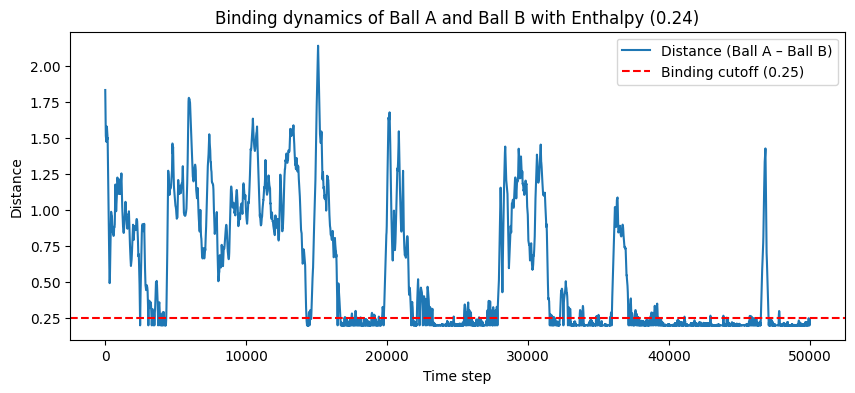

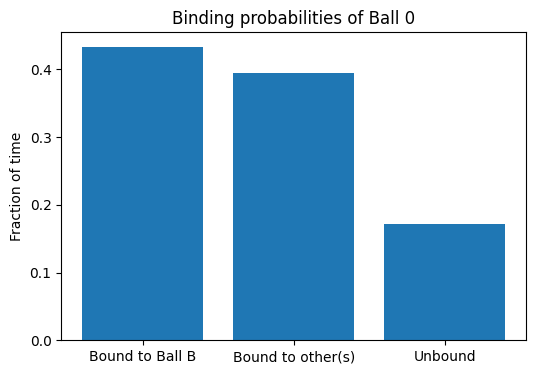

In [ ]:
# @title Binding State Analysis with enthalpy
# -------------------
# Binding analysis
# -------------------
r_bind = radius*2.5
bound_to_1_frames = []
bound_to_others_frames = []
unbound_frames = []

# distances of particle 0 to all others, shape = (n_steps, n_particles-1)
# Need to handle case where n_balls is 0 or 1
if n_balls > 1:
    dists = np.linalg.norm(pos_history_2[:, 1:,:] - pos_history_2[:, [0],:], axis=2)

    # binding checks (mutually exclusive states)
    is_bound_to_1 = (dists[:, 0] < r_bind)
    is_bound_to_any_other = (np.any(dists[:, 1:] < r_bind, axis=1))

    # State 1: Bound to Ball 1 (and potentially others)
    bound_to_1_frames = is_bound_to_1.astype(int)

    # State 2: Bound to others (excluding Ball 1) - bound to any other AND NOT bound to ball 1
    bound_to_others_frames = (is_bound_to_any_other & (~is_bound_to_1)).astype(int)

    # State 3: Unbound - NOT bound to ball 1 AND NOT bound to any other
    unbound_frames = (~is_bound_to_1 & ~is_bound_to_any_other).astype(int)


    dist_01 = dists[:, 0]  # distance from particle 0 to 1

    plt.figure(figsize=(10,4))
    plt.plot(dist_01, label="Distance (Ball A – Ball B)")
    plt.axhline(r_bind, color="r", linestyle="--", label=f"Binding cutoff ({r_bind:.2f})")
    plt.xlabel("Time step"); plt.ylabel("Distance")
    plt.title(f"Binding dynamics of Ball A and Ball B with Enthalpy ({strong_interaction:.2f})")
    plt.legend()
    plt.show()

    # Bar plot of binding frequencies
    counts = [
        np.sum(bound_to_1_frames),
        np.sum(bound_to_others_frames),
        np.sum(unbound_frames)
    ]

    labels = ["Bound to Ball B", f"Bound to other(s)", "Unbound"]

    total_frames = len(bound_to_1_frames)
    if total_frames > 0:
        plt.figure(figsize=(6,4))
        plt.bar(labels, np.array(counts)/total_frames)
        plt.ylabel("Fraction of time")
        plt.title("Binding probabilities of Ball 0")
        plt.show()
    else:
        print("No simulation data available to calculate binding probabilities.")

elif n_balls == 1:
    print("Only one particle in the simulation. Binding analysis requires at least two particles.")
else:
    print("No particles in the simulation.")

# Entropy/Enthalpy analysis
kB = 1.0
Omega_A = 1
Omega_B = n_balls - 2
Omega_C = 1

S_A = kB * np.log(Omega_A)
S_B = kB * np.log(Omega_B)
S_C = kB * np.log(Omega_C)

# Estimate average interaction energy in each state
def interaction_energy(qi, qj, r, k=1.0):
    return k * qi * qj / r

U_A, U_B = [], []
# Ensure pos_history_2 is not empty and has enough particles for analysis
if len(pos_history_2) > 0 and n_balls > 1:
    for step in range(len(pos_history_2)):
        pos0 = pos_history_2[step, 0]
        # Calculate distances from particle 0 to all other particles including particle 1
        dists_all = np.linalg.norm(pos_history_2[step] - pos0, axis=1)

        # Check if particle 0 is bound to particle 1 in this step
        if dists_all[1] < r_bind:
            U_A.append(interaction_energy(charges[0], charges[1], dists_all[1]))
        # Check if particle 0 is bound to any other particle (excluding particle 1) in this step
        for j in range(2, n_balls):
            if dists_all[j] < r_bind:
                U_B.append(interaction_energy(charges[0], charges[j], dists_all[j]))


And lets also look at the simulation.

**NOTE** This is a different kind of visualization that is a bit more memory efficient, which makes a playable movie instead of one where you can step through frames. We do this because you might want to make longer movies here, which would take much too long otherwise.

In [ ]:
# @title Parallel Render and Stitch Movie
import os
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from IPython.display import Video

# --- Parameters ---
start_frame = 0       #@param {type:"integer"}
end_frame = 5000      #@param {type:"integer"}
frame_step = 25      #@param {type:"integer"}
n_jobs = -1           #@param {type:"integer"} # -1 = use all CPU cores
fps = 30              #@param {type:"integer"}
out_file = "simulation.mp4"  #@param {type:"string"}

# Frame range
end_frame = min(end_frame, n_steps)
frames_to_use = np.arange(start_frame, end_frame, frame_step)

# Output dir
out_dir = "frames_tmp"
!rm -rf frames_tmp/*
os.makedirs(out_dir, exist_ok=True)


fsize=4

ms = get_markersize(radius*2, box_size, fsize)

# --- Per-frame rendering function ---
def render_frame(idx, frame):
    fig, ax = plt.subplots(1, 2, figsize=(2*fsize, fsize))

    # Left: particle positions
    ax[0].set_xlim(0, box_size)
    ax[0].set_ylim(0, box_size)
    ax[0].scatter(pos_history_2[frame, :, 0],
                  pos_history_2[frame, :, 1],
                  s=ms, c=charges, cmap="coolwarm")
    ax[0].set_title(f"Frame {frame}")

    # Right: energies
    ax[1].set_xlim(0, end_frame)
    ax[1].plot(total_energy_history_2[:frame], label="Total E")
    ax[1].plot(np.sum(ke_history_2[:frame], axis=1), label="KE")
    ax[1].plot(pe_history_2[:frame], label="PE")
    ax[1].legend()
    ax[1].set_title("Energy vs Time")

    # Save with contiguous numbering
    fname = f"{out_dir}/frame_{idx:05d}.png"
    fig.savefig(fname, dpi=100)
    plt.close(fig)
    return fname

# --- Render in parallel ---
print(f"Rendering {len(frames_to_use)} frames in parallel...")
Parallel(n_jobs=n_jobs, backend="loky")(
    delayed(render_frame)(i, f) for i, f in enumerate(frames_to_use)
)

# --- Stitch with ffmpeg ---
print("Stitching frames into movie...")
!ffmpeg -y -hide_banner -loglevel error -framerate {fps} -i {out_dir}/frame_%05d.png -c:v libx264 -pix_fmt yuv420p {out_file}

# --- Display result inline ---
Video(out_file, embed=True)


Rendering 200 frames in parallel...
Stitching frames into movie...


Here we can see the impact of both enthalpy and entropy on the population of states, and thus how they influence the balance of the system.

**Challenge**:
Try to alter the interaction strenghts and temperature (initial velocity) to balance the population of states. Either balance just the two differnt types of bound states, or all three.

**TIP 1:** You need to run the simulations quite long to get sufficent statistics. Recommend 25k steps or more.

**TIP 2:** Look at the Boltzmann expression for state population. How does temperature influence the relative difference between states?
<details>
<summary>Caveat (click to expand)</summary>
This is a simulation. If you use extreme settings, the simulation will calculate very small or big numbers and become unstable.
</details>

**Question 1:**
Once you have balanced the populations, predict what will happen if you increase the inital velocity slightly, based on the expression
$$\Delta F = -T \cdot \Delta S$$

**Question 2:**
Go back to the settings that balanced your state populations. Now, change the number of balls slightly. Using the same expression as the previous question, predict how the balance will shift.  